# signals

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numba import njit, f8, i8, b1, optional

In [3]:
index = pd.Index([
    datetime(2018, 1, 1),
    datetime(2018, 1, 2),
    datetime(2018, 1, 3),
    datetime(2018, 1, 4),
    datetime(2018, 1, 5)
])
columns = ['a', 'b', 'c']
ts = pd.DataFrame({
    'a': [1, 2, 3, 4, np.nan], 
    'b': [np.nan, 4, 3, 2, 1],
    'c': [1, 2, np.nan, 2, 1]}, index=index).astype(np.float64)

print(ts)

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  NaN
2018-01-04  4.0  2.0  2.0
2018-01-05  NaN  1.0  1.0


In [4]:
big_ts = pd.DataFrame(np.random.randint(10, size=(1000, 1000)).astype(float))
big_ts.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
big_ts.shape

(1000, 1000)

In [5]:
print(pd.Series.vbt.signals.empty(5, index=index))
print(pd.DataFrame.vbt.signals.empty((5, 3), index=index, columns=columns))

%timeit pd.DataFrame.vbt.signals.empty((1000, 1000))

2018-01-01    False
2018-01-02    False
2018-01-03    False
2018-01-04    False
2018-01-05    False
dtype: bool
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False  False  False
2018-01-05  False  False  False
417 µs ± 73.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
@njit
def choice_func_nb(col, from_i, to_i):
    return np.random.choice(np.arange(from_i, to_i), size=1, replace=False)

print(pd.Series.vbt.signals.generate(5, choice_func_nb, index=index))
print(pd.DataFrame.vbt.signals.generate((5, 3), choice_func_nb, index=index, columns=columns))

%timeit pd.DataFrame.vbt.signals.generate((1000, 1000), choice_func_nb)

2018-01-01    False
2018-01-02    False
2018-01-03     True
2018-01-04    False
2018-01-05    False
dtype: bool
                a      b      c
2018-01-01  False   True  False
2018-01-02  False  False   True
2018-01-03  False  False  False
2018-01-04  False  False  False
2018-01-05   True  False  False
18.8 ms ± 667 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
print(pd.Series.vbt.signals.generate_random(5, 2, min_space=1, seed=42, index=index))
print(pd.DataFrame.vbt.signals.generate_random((5, 3), 2, min_space=1, seed=42, index=index, columns=columns))

%timeit pd.DataFrame.vbt.signals.generate_random((1000, 1000), 100)

2018-01-01    False
2018-01-02    False
2018-01-03     True
2018-01-04    False
2018-01-05     True
dtype: bool
                a      b      c
2018-01-01  False  False   True
2018-01-02  False  False  False
2018-01-03   True   True  False
2018-01-04  False  False  False
2018-01-05   True   True   True
19.6 ms ± 2.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
entries = pd.DataFrame.vbt.signals.generate_random((5, 3), 2, min_space=1, seed=42, index=index, columns=columns)
print(entries.shape)

big_entries = pd.DataFrame.vbt.signals.generate_random((1000, 1000), 100, index=big_ts.index)
print(big_entries.shape)

(5, 3)
(1000, 1000)


In [9]:
a = np.random.randint(-1, 2, size=(5, 3))
print(a)

big_a = np.random.randint(-1, 2, size=(1000, 1000))
print(big_a.shape)

[[-1 -1  0]
 [ 1 -1 -1]
 [-1  1 -1]
 [ 0  0 -1]
 [ 1  0  0]]
(1000, 1000)


In [10]:
@njit
def entry_func_nb(col, from_i, to_i, a):
    # First positive value of a after last exit
    return from_i + np.flatnonzero(a[from_i:to_i, col] > 0)[:1]

@njit
def exit_func_nb(col, from_i, to_i, a):
    # First negative value of a after last entry
    return from_i + np.flatnonzero(a[from_i:to_i, col] < 0)[:1]

print(pd.Series.vbt.signals.generate_iteratively(a.shape[0], entry_func_nb, exit_func_nb, a, index=index))
print(pd.DataFrame.vbt.signals.generate_iteratively(a.shape, entry_func_nb, exit_func_nb, a, index=index, columns=columns))

%timeit pd.DataFrame.vbt.signals.generate_iteratively(big_a.shape, entry_func_nb, exit_func_nb, big_a)

(2018-01-01    False
2018-01-02     True
2018-01-03    False
2018-01-04    False
2018-01-05     True
dtype: bool, 2018-01-01    False
2018-01-02    False
2018-01-03     True
2018-01-04    False
2018-01-05    False
dtype: bool)
(                a      b      c
2018-01-01  False  False  False
2018-01-02   True  False  False
2018-01-03  False   True  False
2018-01-04  False  False  False
2018-01-05   True  False  False,                 a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03   True  False  False
2018-01-04  False  False  False
2018-01-05  False  False  False)
3.88 s ± 445 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
@njit
def choice_func_nb(col, from_i, to_i):
    return np.random.choice(np.arange(from_i, to_i), size=1, replace=False)

print(entries.vbt.signals.generate_after(choice_func_nb))

%timeit big_entries.vbt.signals.generate_after(choice_func_nb)

                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False   True
2018-01-04   True   True  False
2018-01-05  False  False  False
201 ms ± 56.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
print(entries.vbt.signals.generate_random_after(2, seed=42))

%timeit big_entries.vbt.signals.generate_random_after(2, seed=42)

                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False   True
2018-01-03  False  False   True
2018-01-04   True   True  False
2018-01-05  False  False  False
188 ms ± 6.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
e = pd.Series([True, False, False, False, False, False])
t = pd.Series([2, 3, 4, 3, 2, 1]).astype(np.float64)

print(e.vbt.signals.generate_stop_loss(t, 0.1))
print(e.vbt.signals.generate_stop_loss(t, 0.1, trailing=True))
print(e.vbt.signals.generate_stop_loss(t, 0.1, trailing=True, first=False))

0    False
1    False
2    False
3    False
4    False
5     True
Name: (0.1, nan), dtype: bool
0    False
1    False
2    False
3     True
4    False
5    False
Name: (0.1, nan), dtype: bool
0    False
1    False
2    False
3     True
4     True
5     True
Name: (0.1, nan), dtype: bool


In [14]:
print(entries['a'].vbt.signals.generate_stop_loss(ts['a'], 0.1))
%timeit big_entries.iloc[:, 0].vbt.signals.generate_stop_loss(big_ts.iloc[:, 0], 0.1)

print(entries.vbt.signals.generate_stop_loss(ts['a'], 0.1))
%timeit big_entries.vbt.signals.generate_stop_loss(big_ts.iloc[:, 0], 0.1)

print(entries.vbt.signals.generate_stop_loss(ts, 0.1))
%timeit big_entries.vbt.signals.generate_stop_loss(big_ts, 0.1)

print(entries.vbt.signals.generate_stop_loss(ts, [0.1, 0.5])) # test frame-wise stops
%timeit big_entries.vbt.signals.generate_stop_loss(big_ts, np.arange(0, 1, 0.1))

print(entries.vbt.signals.generate_stop_loss(ts, np.random.uniform(size=(2, 5, 3)))) # test element-wise stops
%timeit big_entries.vbt.signals.generate_stop_loss(big_ts, np.random.uniform(size=(10, 1000, 1000)))

2018-01-01    False
2018-01-02    False
2018-01-03    False
2018-01-04    False
2018-01-05    False
Name: (0.1, a), dtype: bool
9.06 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False  False  False
2018-01-05  False  False  False
201 ms ± 3.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False   True  False
2018-01-05  False  False  False
193 ms ± 9.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
stop_loss     0.1                  0.5              
                a      b      c      a      b      c
2018-01-01  False  False  False  False  False  False
2018-01-02  False  False  False  False  False  False
2018-01-03  False  False  False  False  False  False
2018-01-04  False

In [15]:
print(entries['a'].vbt.signals.generate_stop_loss(ts['a'], 0.1, trailing=True))
%timeit big_entries.iloc[:, 0].vbt.signals.generate_stop_loss(big_ts.iloc[:, 0], 0.1, trailing=True)

print(entries.vbt.signals.generate_stop_loss(ts['a'], 0.1, trailing=True))
%timeit big_entries.vbt.signals.generate_stop_loss(big_ts.iloc[:, 0], 0.1, trailing=True)

print(entries.vbt.signals.generate_stop_loss(ts, 0.1, trailing=True))
%timeit big_entries.vbt.signals.generate_stop_loss(big_ts, 0.1, trailing=True)

print(entries.vbt.signals.generate_stop_loss(ts, [0.1, 0.5], trailing=True)) # test frame-wise stops
%timeit big_entries.vbt.signals.generate_stop_loss(big_ts, np.arange(0, 1, 0.1), trailing=True)

print(entries.vbt.signals.generate_stop_loss(ts, np.random.uniform(size=(2, 5, 3)), trailing=True)) # test element-wise stops
%timeit big_entries.vbt.signals.generate_stop_loss(big_ts, np.random.uniform(size=(10, 1000, 1000)), trailing=True)

2018-01-01    False
2018-01-02    False
2018-01-03    False
2018-01-04    False
2018-01-05    False
Name: (0.1, a), dtype: bool
9.67 ms ± 479 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False  False  False
2018-01-05  False  False  False
290 ms ± 26.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False   True  False
2018-01-05  False  False  False
277 ms ± 9.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
trail_stop    0.1                  0.5              
                a      b      c      a      b      c
2018-01-01  False  False  False  False  False  False
2018-01-02  False  False  False  False  False  False
2018-01-03  False  False  False  False  False  False
2018-01-04  Fals

In [16]:
e = pd.Series([True, False, False, False, False])
t = pd.Series([2, 1, 2, 3, 4]).astype(np.float64)

print(e.vbt.signals.generate_take_profit(t, 0.1))
print(e.vbt.signals.generate_take_profit(t, 0.1, first=False))

0    False
1    False
2    False
3     True
4    False
Name: (0.1, nan), dtype: bool
0    False
1    False
2    False
3     True
4     True
Name: (0.1, nan), dtype: bool


In [17]:
print(entries['a'].vbt.signals.generate_take_profit(ts['a'], 0.1))
%timeit big_entries.iloc[:, 0].vbt.signals.generate_take_profit(big_ts.iloc[:, 0], 0.1)

print(entries.vbt.signals.generate_take_profit(ts['a'], 0.1))
%timeit big_entries.vbt.signals.generate_take_profit(big_ts.iloc[:, 0], 0.1)

print(entries.vbt.signals.generate_take_profit(ts, 0.1))
%timeit big_entries.vbt.signals.generate_take_profit(big_ts, 0.1)

print(entries.vbt.signals.generate_take_profit(ts, [0.1, 0.5])) # test frame-wise stops
%timeit big_entries.vbt.signals.generate_take_profit(big_ts, np.arange(0, 1, 0.1))

print(entries.vbt.signals.generate_take_profit(ts, np.random.uniform(size=(2, 5, 3)))) # test element-wise stops
%timeit big_entries.vbt.signals.generate_take_profit(big_ts, np.random.uniform(size=(10, 1000, 1000)))

2018-01-01    False
2018-01-02    False
2018-01-03    False
2018-01-04     True
2018-01-05    False
Name: (0.1, a), dtype: bool
9.44 ms ± 844 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False   True
2018-01-03  False  False  False
2018-01-04   True   True  False
2018-01-05  False  False  False
243 ms ± 29.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False   True
2018-01-03  False  False  False
2018-01-04   True  False  False
2018-01-05  False  False  False
202 ms ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
take_profit    0.1                  0.5              
                 a      b      c      a      b      c
2018-01-01   False  False  False  False  False  False
2018-01-02   False  False   True  False  False   True
2018-01-03   False  False  False  False  False  False
2018-01-04  

In [18]:
distance_map_nb = njit(lambda col, prev_i, next_i: next_i - prev_i)
avg_reduce_nb = njit(lambda col, a: np.nanmean(a))

print(entries.vbt.signals.map_reduce_between(map_func_nb=distance_map_nb, reduce_func_nb=avg_reduce_nb))

%timeit big_entries.vbt.signals.map_reduce_between(map_func_nb=distance_map_nb, reduce_func_nb=avg_reduce_nb)

a    2.0
b    2.0
c    4.0
dtype: float64
5.28 ms ± 200 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
print(entries.vbt.signals.map_reduce_between(
    other=entries.vbt.signals.fshift(1), 
    map_func_nb=distance_map_nb, 
    reduce_func_nb=avg_reduce_nb))

%timeit big_entries.vbt.signals.map_reduce_between(\
    other=big_entries.vbt.signals.fshift(1),\
    map_func_nb=distance_map_nb,\
    reduce_func_nb=avg_reduce_nb)

a    1.0
b    1.0
c    1.0
dtype: float64
93 ms ± 2.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
print(entries.vbt.signals.map_reduce_partitions(map_func_nb=distance_map_nb, reduce_func_nb=avg_reduce_nb))

%timeit big_entries.vbt.signals.map_reduce_partitions(map_func_nb=distance_map_nb, reduce_func_nb=avg_reduce_nb)

a    1.0
b    1.0
c    1.0
dtype: float64
4.16 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
print(entries['a'].vbt.signals.num_signals)
print(entries.vbt.signals.num_signals)

%timeit big_entries.vbt.signals.num_signals # cached

2
a    2
b    2
c    2
dtype: int64
1.08 µs ± 66.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [22]:
print(entries['a'].vbt.signals.avg_distance)
print(entries.vbt.signals.avg_distance)

%timeit big_entries.vbt.signals.avg_distance # cached

2.0
a    2.0
b    2.0
c    4.0
dtype: float64
1.09 µs ± 45.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [23]:
print(entries['a'].vbt.signals.avg_distance_to(entries['a'].vbt.signals.fshift(1)))
print(entries.vbt.signals.avg_distance_to(entries.vbt.signals.fshift(1)))

%timeit big_entries.vbt.signals.avg_distance_to(big_entries.vbt.signals.fshift(1)) # cached

1.0
a    1.0
b    1.0
c    1.0
dtype: float64
94.2 ms ± 2.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
print(entries['a'].vbt.signals.rank())
print(entries.vbt.signals.rank())

print(entries['a'].vbt.signals.rank(after_false=True))
print(entries.vbt.signals.rank(after_false=True))

print(entries['a'].vbt.signals.rank(allow_gaps=True))
print(entries.vbt.signals.rank(allow_gaps=True))

print(entries['a'].vbt.signals.rank(allow_gaps=True, reset_by=~entries['a']))
print(entries.vbt.signals.rank(allow_gaps=True, reset_by=~entries))

%timeit big_entries.vbt.signals.rank()

2018-01-01    0
2018-01-02    0
2018-01-03    1
2018-01-04    0
2018-01-05    1
Name: a, dtype: int64
            a  b  c
2018-01-01  0  0  1
2018-01-02  0  0  0
2018-01-03  1  1  0
2018-01-04  0  0  0
2018-01-05  1  1  1
2018-01-01    0
2018-01-02    0
2018-01-03    1
2018-01-04    0
2018-01-05    1
Name: a, dtype: int64
            a  b  c
2018-01-01  0  0  0
2018-01-02  0  0  0
2018-01-03  1  1  0
2018-01-04  0  0  0
2018-01-05  1  1  1
2018-01-01    0
2018-01-02    0
2018-01-03    1
2018-01-04    0
2018-01-05    2
Name: a, dtype: int64
            a  b  c
2018-01-01  0  0  1
2018-01-02  0  0  0
2018-01-03  1  1  0
2018-01-04  0  0  0
2018-01-05  2  2  2
2018-01-01    0
2018-01-02    0
2018-01-03    1
2018-01-04    0
2018-01-05    1
Name: a, dtype: int64
            a  b  c
2018-01-01  0  0  1
2018-01-02  0  0  0
2018-01-03  1  1  0
2018-01-04  0  0  0
2018-01-05  1  1  1
5.64 ms ± 215 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
print(entries['a'].vbt.signals.rank_partitions())
print(entries.vbt.signals.rank_partitions())

print(entries['a'].vbt.signals.rank_partitions(after_false=True))
print(entries.vbt.signals.rank_partitions(after_false=True))

print(entries['a'].vbt.signals.rank_partitions(reset_by=~entries['a']))
print(entries.vbt.signals.rank_partitions(reset_by=~entries))

%timeit big_entries.vbt.signals.rank_partitions()

2018-01-01    0
2018-01-02    0
2018-01-03    1
2018-01-04    0
2018-01-05    2
Name: a, dtype: int64
            a  b  c
2018-01-01  0  0  1
2018-01-02  0  0  0
2018-01-03  1  1  0
2018-01-04  0  0  0
2018-01-05  2  2  2
2018-01-01    0
2018-01-02    0
2018-01-03    1
2018-01-04    0
2018-01-05    2
Name: a, dtype: int64
            a  b  c
2018-01-01  0  0  0
2018-01-02  0  0  0
2018-01-03  1  1  0
2018-01-04  0  0  0
2018-01-05  2  2  1
2018-01-01    0
2018-01-02    0
2018-01-03    1
2018-01-04    0
2018-01-05    1
Name: a, dtype: int64
            a  b  c
2018-01-01  0  0  1
2018-01-02  0  0  0
2018-01-03  1  1  0
2018-01-04  0  0  0
2018-01-05  1  1  1
6 ms ± 202 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
print(entries.vbt.signals.first())

%timeit big_entries.vbt.signals.first()

                a      b      c
2018-01-01  False  False   True
2018-01-02  False  False  False
2018-01-03   True   True  False
2018-01-04  False  False  False
2018-01-05   True   True   True
6.76 ms ± 221 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
print(entries & (ts > 1))
%timeit big_entries & (big_ts > 1)

print(entries.vbt.signals.AND(ts.values > 1))
%timeit big_entries.vbt.signals.AND(big_ts.values > 1)

                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03   True   True  False
2018-01-04  False  False  False
2018-01-05  False  False  False
518 ms ± 41.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03   True   True  False
2018-01-04  False  False  False
2018-01-05  False  False  False


/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


2.73 ms ± 257 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
print(entries.vbt.signals.OR(ts > 1, ts > 2, ts > 3)) # you can pass multiple arguments
print(entries.vbt.signals.OR(ts > 1, ts > 2, ts > 3, concat=True, as_columns=['>1', '>2', '>3']))

                a      b      c
2018-01-01  False  False   True
2018-01-02   True   True   True
2018-01-03   True   True  False
2018-01-04   True   True   True
2018-01-05   True   True   True
               >1                   >2                   >3              
                a      b      c      a      b      c      a      b      c
2018-01-01  False  False   True  False  False   True  False  False   True
2018-01-02   True   True   True  False   True  False  False   True  False
2018-01-03   True   True  False   True   True  False   True   True  False
2018-01-04   True   True   True   True  False  False   True  False  False
2018-01-05   True   True   True   True   True   True   True   True   True


In [29]:
print(entries.vbt.signals.shuffle(seed=42))

%timeit big_entries.vbt.signals.shuffle(seed=42)

                a      b      c
2018-01-01  False  False  False
2018-01-02   True  False   True
2018-01-03   True   True  False
2018-01-04  False  False   True
2018-01-05  False   True  False
22.9 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
print(entries.vbt.signals.fshift(2))

%timeit big_entries.vbt.signals.fshift(2)

                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False   True
2018-01-04  False  False  False
2018-01-05   True   True  False
1.3 ms ± 77.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


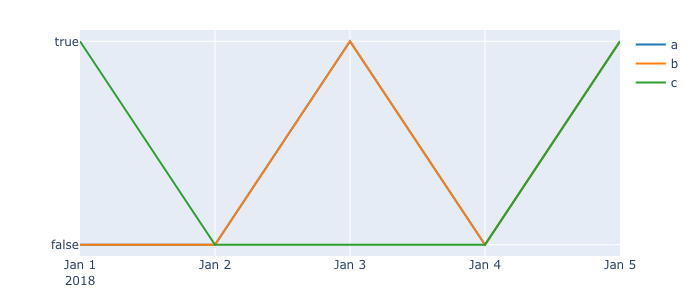

In [31]:
entries.vbt.signals.plot().show_png()

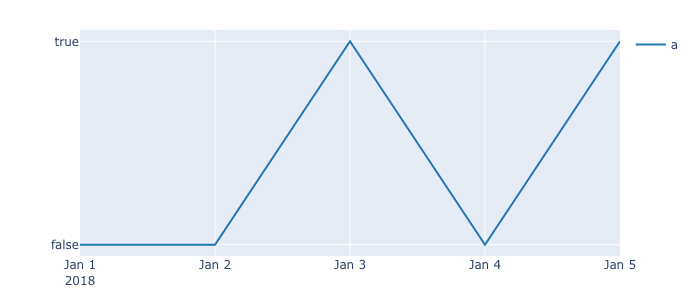

In [32]:
entries['a'].vbt.signals.plot().show_png()

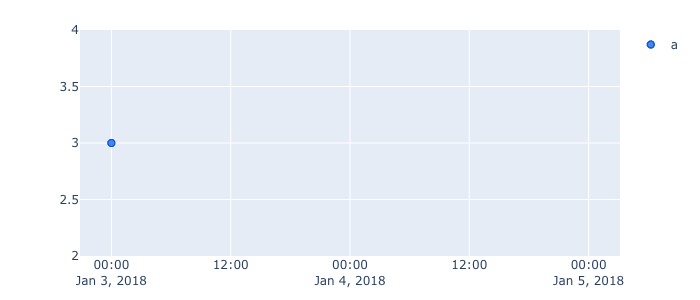

In [33]:
entries['a'].vbt.signals.plot_as_markers(ts['a']).show_png()

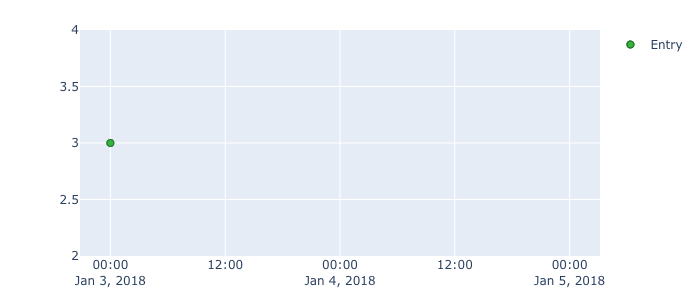

In [34]:
entries['a'].vbt.signals.plot_as_entry_markers(ts['a']).show_png()

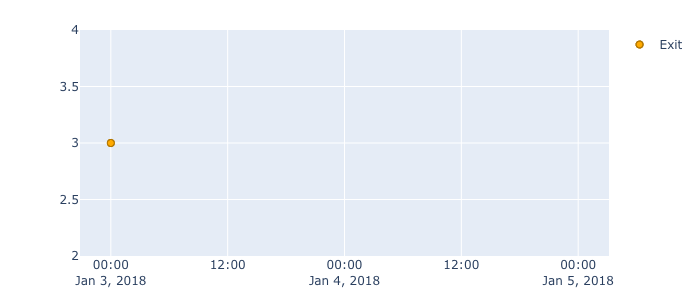

In [35]:
entries['a'].vbt.signals.plot_as_exit_markers(ts['a']).show_png()